Произведите fine-tuning модели bert-base-uncased на датасете GLUE SST-2 с использованием препроцессинга.

In [1]:
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Загрузка данных и компонентов
raw_datasets = load_dataset("glue", "sst2")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Определение функции токенизации
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=True)

# Применение токенизации ко всему набору данных
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Переименование колонки, чтобы она соответствовала ожиданиям модели
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Функция для вычисления метрик
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Загрузка модели PyTorch
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Настройка аргументов обучения с включением логирования
training_args = TrainingArguments(
    "./test-trainer",
    num_train_epochs=2,
    evaluation_strategy="epoch",      # Оценка после каждой эпохи
    logging_strategy="epoch",         # Логирование после каждой эпохи
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Создание тренера
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Запуск обучения
trainer.train()


/home/user/miniconda3/envs/ds-vl2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/miniconda3/envs/ds-vl2/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 1821/1821 [00:00<00:00, 26339.88 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 8419/16838 [20:31<23:09,  6.06it/s]

{'loss': 0.292, 'grad_norm': 0.3786132037639618, 'learning_rate': 2.5e-05, 'epoch': 1.0}


                                                    
 50%|█████     | 8419/16838 [20:38<23:09,  6.06it/s]

{'eval_loss': 0.3813032805919647, 'eval_accuracy': 0.9013761467889908, 'eval_runtime': 7.2899, 'eval_samples_per_second': 119.617, 'eval_steps_per_second': 14.952, 'epoch': 1.0}


100%|██████████| 16838/16838 [42:13<00:00,  6.91it/s]  

{'loss': 0.1453, 'grad_norm': 16.265310287475586, 'learning_rate': 0.0, 'epoch': 2.0}


                                                     
100%|██████████| 16838/16838 [42:20<00:00,  6.91it/s]

{'eval_loss': 0.39360928535461426, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 7.2609, 'eval_samples_per_second': 120.095, 'eval_steps_per_second': 15.012, 'epoch': 2.0}


100%|██████████| 16838/16838 [43:24<00:00,  6.46it/s]

{'train_runtime': 2604.7765, 'train_samples_per_second': 51.712, 'train_steps_per_second': 6.464, 'train_loss': 0.21863969593748145, 'epoch': 2.0}


TrainOutput(global_step=16838, training_loss=0.21863969593748145, metrics={'train_runtime': 2604.7765, 'train_samples_per_second': 51.712, 'train_steps_per_second': 6.464, 'train_loss': 0.21863969593748145, 'epoch': 2.0})

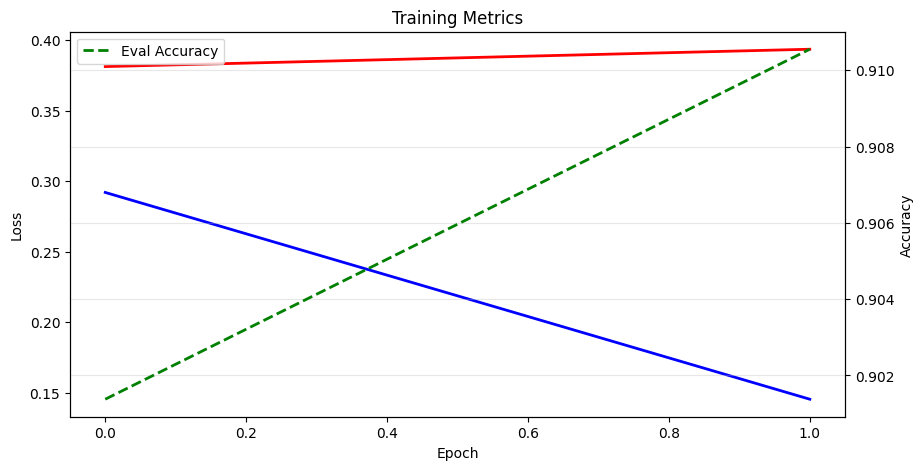

In [3]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

# Извлекаем метрики
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

# Строим график
plt.figure(figsize=(10, 5))

# Левый Y-axis для loss
plt.plot(train_loss, 'b-', label='Train Loss', linewidth=2)
plt.plot(eval_loss, 'r-', label='Eval Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss', color='black')

# Правый Y-axis для accuracy
plt.twinx()
plt.plot(eval_accuracy, 'g--', label='Eval Accuracy', linewidth=2)
plt.ylabel('Accuracy', color='black')

plt.title('Training Metrics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()